<center>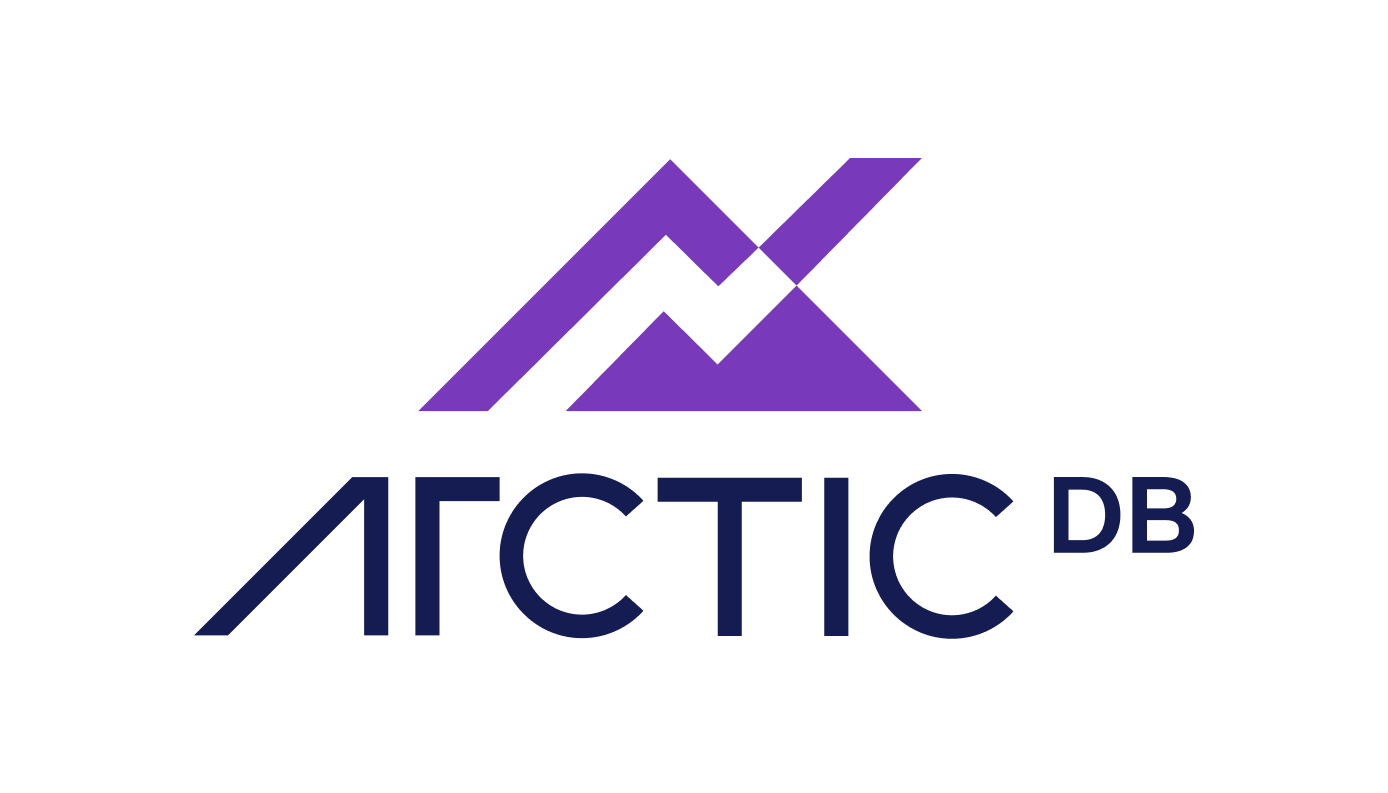
</center>

# ArcticDB Staged Data with Tokens Demo

## Preamble

In [1]:
import pandas as pd
import numpy as np
import time
from multiprocessing import Process, Queue

from arcticdb.exceptions import NoSuchVersionException, UnsortedDataException
from arcticdb import Arctic, LibraryOptions

def make_df(rows: int, cols: int, start_date):
    index = pd.date_range(start=pd.to_datetime(start_date), periods=rows, freq="D")
    data = np.arange(1, rows * cols + 1).reshape(rows, cols, order="F")
    return pd.DataFrame(data, index=index, columns=[f"col_{i}" for i in range(cols)])

# Below library is configured to have only 2 rows per segment. This is to make the example more readable as the default is 100 000 rows per segment.    
def get_lib():
    return Arctic("lmdb://tmp/stage_tokens_demo").get_library("stage_tokens_demo", library_options=LibraryOptions(rows_per_segment=2), create_if_missing=True)

def clear_lib():
    get_lib()._nvs.version_store.clear()

sym = "sym"
clear_lib()
lib = get_lib()

In [2]:
df1 = make_df(rows=1, cols=3, start_date="2025-01-01")
df2 = make_df(rows=1, cols=3, start_date="2025-01-02")
df3 = make_df(rows=1, cols=3, start_date="2025-01-03")

In [3]:
df1

,col_0,col_1,col_2
2025-01-01,1,2,3


In [4]:
df2

,col_0,col_1,col_2
2025-01-02,1,2,3


In [5]:
df3

,col_0,col_1,col_2
2025-01-03,1,2,3


## Old API (still available)

In [6]:
lib.stage(sym, df1)

In [7]:
lib.stage(sym, df2)

In [8]:
lib.stage(sym, df3)

In [9]:
try: 
    lib.read(sym)
except NoSuchVersionException:
    print("No verioned data")

No verioned data


In [10]:
lib.finalize_staged_data(sym)


VersionedItem(symbol='sym', library='stage_tokens_demo', data=n/a, version=0, metadata=None, host='LMDB(path=/data/team/data/arctic_native/examples/arctcdb_staged_data_with_tokens/tmp/stage_tokens_demo)', timestamp=1757155536230406795)

In [11]:
lib.read(sym).data

,col_0,col_1,col_2
2025-01-01,1,2,3
2025-01-02,1,2,3
2025-01-03,1,2,3


In [12]:
clear_lib()

## New API

#### Control over which segments to compact

In [13]:
stage_result_df1 = lib.stage(sym, df1)

In [14]:
stage_result_df2 = lib.stage(sym, df2)

In [15]:
stage_result_df3 = lib.stage(sym, df3)

In [16]:
lib.finalize_staged_data(sym, stage_results=[stage_result_df1, stage_result_df3])

VersionedItem(symbol='sym', library='stage_tokens_demo', data=n/a, version=1, metadata=None, host='LMDB(path=/data/team/data/arctic_native/examples/arctcdb_staged_data_with_tokens/tmp/stage_tokens_demo)', timestamp=1757155536735859381)

In [17]:
lib.read(sym).data

,col_0,col_1,col_2
2025-01-01,1,2,3
2025-01-03,1,2,3


#### df2 is still in the staged index, while df1 and df3 are not

In [18]:

lib.finalize_staged_data(sym, stage_results=[stage_result_df2])

VersionedItem(symbol='sym', library='stage_tokens_demo', data=n/a, version=2, metadata=None, host='LMDB(path=/data/team/data/arctic_native/examples/arctcdb_staged_data_with_tokens/tmp/stage_tokens_demo)', timestamp=1757155536921636632)

In [19]:
lib.read(sym).data

,col_0,col_1,col_2
2025-01-02,1,2,3


#### Now there is no more staged data

In [20]:
lib.get_staged_symbols()

[]

In [21]:
clear_lib()

## Why do we need this?

### Reason 1: Unpredictable data in an event of a crash etc.

Writes to storage of a single stage() are sometimes more than 1 (if the data is big enough). This means that if the process doesn't finish for some reason (like crash, preemption, etc) it is still possible that it had written some staged data to storage.

In [22]:
df = make_df(rows=10, cols=3, start_date="2025-01-01")
df

,col_0,col_1,col_2
2025-01-01,1,11,21
2025-01-02,2,12,22
2025-01-03,3,13,23
2025-01-04,4,14,24
2025-01-05,5,15,25
2025-01-06,6,16,26
2025-01-07,7,17,27
2025-01-08,8,18,28
2025-01-09,9,19,29
2025-01-10,10,20,30


simulated failure modes

In [23]:
def succeeds(q):
    q.put(lib.stage(sym, df))

def crashes_before_stage(*args):
    raise RuntimeError()

def crashes_after_stage(*args):
    lib.stage(sym, df)
    raise RuntimeError()

In [24]:
def start_stage_worker(failure_mode):
    q = Queue()
    worker = Process(target=failure_mode, args=(q,))
    worker.start()
    worker.join()
    if worker.exitcode == 0:
        return q.get()

In [25]:
start_stage_worker(failure_mode=crashes_after_stage)

Process Process-1:
Traceback (most recent call last):
  File "/pegasus-311-1-venv/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/pegasus-311-1-venv/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_12191/2200260244.py", line 9, in crashes_after_stage
    raise RuntimeError()
RuntimeError


#### Now that the process has crashed do you restart it to compact again? Doing so may result in duplicated data

In [26]:
start_stage_worker(failure_mode=succeeds)

In [27]:
try:
    lib.finalize_staged_data(sym)
except UnsortedDataException:
    print("Error: Unsorted data")

Error: Unsorted data


In [28]:
clear_lib()

Previously to fix this kind of problem you had to clear out all staged segments in storage and stage them again.

#### Solution now - compact only successfully completed processes. Now you could rerun a failed job, no matter how it failed, without an issue by passing the correct stage token to finalize.

In [29]:
start_stage_worker(failure_mode=crashes_after_stage)

Process Process-3:
Traceback (most recent call last):
  File "/pegasus-311-1-venv/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/pegasus-311-1-venv/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_12191/2200260244.py", line 9, in crashes_after_stage
    raise RuntimeError()
RuntimeError


In [30]:
start_stage_worker(failure_mode=crashes_before_stage)

Process Process-4:
Traceback (most recent call last):
  File "/pegasus-311-1-venv/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/pegasus-311-1-venv/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_12191/2200260244.py", line 5, in crashes_before_stage
    raise RuntimeError()
RuntimeError


In [31]:
stage_result = start_stage_worker(failure_mode=succeeds)

In [32]:
lib.finalize_staged_data(sym, stage_results=[stage_result])

VersionedItem(symbol='sym', library='stage_tokens_demo', data=n/a, version=0, metadata=None, host='LMDB(path=/data/team/data/arctic_native/examples/arctcdb_staged_data_with_tokens/tmp/stage_tokens_demo)', timestamp=1757155538120611508)

In [33]:
lib.read(sym).data

,col_0,col_1,col_2
2025-01-01,1,11,21
2025-01-02,2,12,22
2025-01-03,3,13,23
2025-01-04,4,14,24
2025-01-05,5,15,25
2025-01-06,6,16,26
2025-01-07,7,17,27
2025-01-08,8,18,28
2025-01-09,9,19,29
2025-01-10,10,20,30


This was a simplified example of a common workflow that is to stage data using a pool of Spark workers. However Spark can (and frequently does) preempt a running job, interrupting it on the worker and replacing it with a different queued job and later restarting it (this is to provide some fairness in scheduling across the cluster). For this reason, Spark tasks should be idempotent. The new API makes them so as the StageResult is only returned if the task is completed succesfully. If any fails, it won't produce a StageResult and thus it won't be finalized.

Another usage pattern is data from a vendor that is sharded to multiple symbols in Arctic, so a single spark worker will stage data for multiple symbols

This leaves the possibility to have orphaned data in storage that is unreachable and not associated with any StageResult. That data can be later removed with `delete_staged_data(sym)` 

In [34]:
lib.get_staged_symbols()

['sym']

In [35]:
lib.delete_staged_data(sym)
lib.get_staged_symbols()

[]

In [36]:
clear_lib()

### Reason 2: Staging while finalizing

Currently users must completely stop staging data while finalize_staged_data is invoked. Now they can stage a batch of data, call finalize_staged_data to write it, and while the finalization is running continue to stage the next batch of data.

In [37]:
def create_worker_for_date(date, rows):
        lib = get_lib()
        df = make_df(rows=rows, cols=3, start_date=date)
        stage_result = lib.stage(sym,df)

def create_compact_worker(stage_results=None):
        lib = get_lib()
        lib.finalize_staged_data(sym, stage_results=stage_results)

##### Currently finalizing while a stage is going on is not allowed because the result is unexpected

In [38]:
lib.stage(sym, make_df(300, 3, "2025-01-01"))
stage_worker = Process(target=create_worker_for_date, args=("2028-01-01", 300))
compact_worker = Process(target=create_compact_worker)

stage_worker.start()
compact_worker.start()

stage_worker.join()
compact_worker.join()

lib.read(sym).data

,col_0,col_1,col_2
2025-01-01,1,301,601
2025-01-02,2,302,602
2025-01-03,3,303,603
2025-01-04,4,304,604
2025-01-05,5,305,605
...,...,...,...
2025-10-25,298,598,898
2025-10-26,299,599,899
2025-10-27,300,600,900
2028-01-01,1,301,601


In [39]:
clear_lib()

##### This can now be solved with the tokens

In [40]:
stage_result = lib.stage(sym, make_df(300, 3, "2025-01-01"))
stage_worker = Process(target=create_worker_for_date, args=("2028-01-01", 300))
compact_worker = Process(target=create_compact_worker, args=([stage_result],)) # Same as above, but here we pass in stage_result into finalize

stage_worker.start()
compact_worker.start()

stage_worker.join()
compact_worker.join()

lib.read(sym).data

,col_0,col_1,col_2
2025-01-01,1,301,601
2025-01-02,2,302,602
2025-01-03,3,303,603
2025-01-04,4,304,604
2025-01-05,5,305,605
...,...,...,...
2025-10-23,296,596,896
2025-10-24,297,597,897
2025-10-25,298,598,898
2025-10-26,299,599,899


### Reason 3: Performance

There is a performance improvement with the new API. By providing the staged tokens, it is no longer needed to list all keys for staged data as they are provided in the StageResult structure.